In [3]:
from uproot_io import Events, View
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math
#titlesize = 20
#labelsize = 14
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.datasets import make_classification

In [ ]:
np.load("fall.npy", fall)
np.save("ftrk", ftrk)
np.save("fshw", fshw)
np.save("lall", lall)
np.save("ltrk", ltrk)
np.save("lshw", lshw)
np.save("truth", truth)

In [4]:
events = Events(r"C:\Users\andre\Desktop\Physics Project\bigdata\CheatedRecoFile_1.root")

In [5]:
training = np.load("training_events.npy")
testing = np.load("testing_events.npy")
truth = np.load("truth_data.npy")
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test_all = np.load("x_test.npy")
y_test_all = np.load("y_test.npy")

In [6]:
max(events.event_number)

9309

In [7]:
def biggest():
    biggest = []
    eventlabel = []
    tslabel = []
    biggest = []
    party = []
    idexz = []
    
    for n in testing:
        nhits = 0
        big = []
        idx = np.where(events.event_number == n)[0]
        
        for i in idx:
            x = events.reco_hits_x_w[i]
            z = events.reco_hits_w[i]
            pdg = events.mc_pdg[i]
            purity = events.purity[i]
            complete = events.completeness[i]
            
            if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
                idexz.append(i)
                if len(x) > nhits:
                    nhits = len(x)
                    big.append(i)
        
        if len(big) != 0:
            biggest.append(big[-1])

            x = events.reco_hits_x_w[big[-1]]
            z = events.reco_hits_w[big[-1]]
            pdg = events.mc_pdg[big[-1]]
            purity = events.purity[big[-1]]
            complete = events.completeness[big[-1]]

            if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:    
                party.append(pdg)
                if pdg == 22. or pdg == -11. or pdg == 11.:
                    tslabel.append(0) #showers
                else:
                    tslabel.append(1) #tracks
            
            if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
                if truth[n] == 0:
                    eventlabel.append(0) #muon
                if truth[n] == 1:
                    eventlabel.append(1) #electron
                if truth[n] == 2:
                    eventlabel.append(2) #nc
    
    return biggest, eventlabel, tslabel, party, idexz

In [8]:
big, eventlabel, tslabel, particle, idexz = biggest()

In [9]:
big = np.array(big)
eventlabel = np.array(eventlabel)
idexz = np.array(idexz)
keep = np.where(eventlabel != 2)
bigcut = big[keep]

In [10]:
common_elements1 = np.intersect1d(idexz, big)
allindices = np.flatnonzero(np.isin(idexz, common_elements1))
common_elements2 = np.intersect1d(idexz, bigcut)
cutindices = np.flatnonzero(np.isin(idexz, common_elements2))

In [11]:
x_test = x_test_all[allindices]
y_test = y_test_all[allindices]

In [12]:
np.shape(x_test)

(2729, 5)

In [13]:
# Create the BDT with a base decision tree classifier (this is the default base classifier, included for illustration)
base = DecisionTreeClassifier(max_depth=14)
bdt = AdaBoostClassifier(estimator=base, n_estimators=100, random_state=0)
# Fit the BDT to the training set
bdt.fit(x_train, y_train)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=14),
                   n_estimators=100, random_state=0)

In [14]:
# Check the training set classification performance
bdt.score(x_train, y_train)

1.0

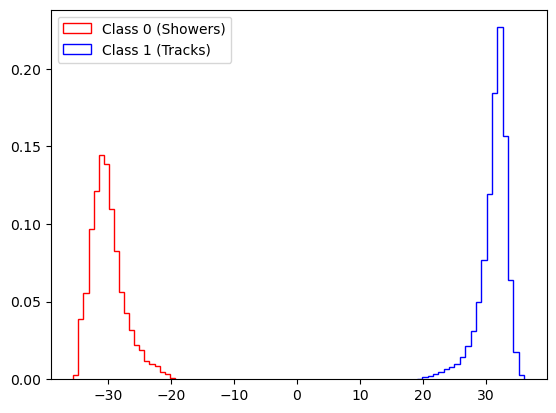

In [15]:
f0 = bdt.decision_function(x_train)
min_f = np.round(np.min(f0), 1)
max_f = np.round(np.max(f0), 1)
#bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)
bins = 20
cls_0_f0 = f0[np.where(y_train == 0)]
cls_1_f0 = f0[np.where(y_train == 1)]
weights_0 = np.ones_like(cls_0_f0) / len(cls_0_f0)
weights_1 = np.ones_like(cls_1_f0) / len(cls_1_f0)
plt.hist(cls_0_f0, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0 (Showers)')
plt.hist(cls_1_f0, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1 (Tracks)')
plt.legend()

In [16]:
# Check the test set classification performance
bdt.score(x_test, y_test)

0.9930377427629168

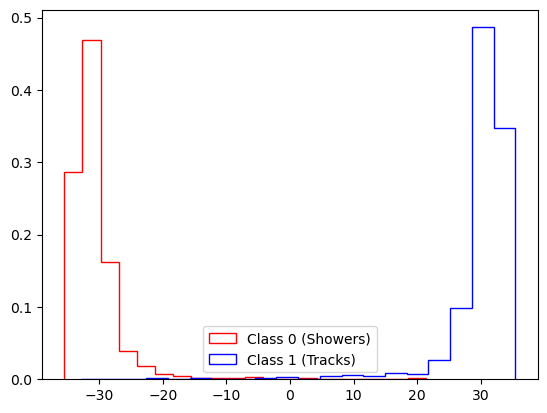

In [17]:
f = bdt.decision_function(x_test)
min_f = np.round(np.min(f), 1)
max_f = np.round(np.max(f), 1)
#bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)
bins = 20
cls_0_f = f[np.where(y_test == 0)]
cls_1_f = f[np.where(y_test == 1)]
weights_0 = np.ones_like(cls_0_f) / len(cls_0_f)
weights_1 = np.ones_like(cls_1_f) / len(cls_1_f)
plt.hist(cls_0_f, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0 (Showers)')
plt.hist(cls_1_f, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1 (Tracks)')
plt.legend()

In [18]:
print(min(cls_0_f)), print(max(cls_1_f))

-35.487770622752855
35.43387184223213


(None, None)

In [19]:
#indexx = np.where(eventlabel != 2)
#cutevents = eventlabel[indexx]

muons = f[np.where(eventlabel == 0)]
electrons = f[np.where(eventlabel == 1)]
nc = f[np.where(eventlabel == 2)]
len(muons), len(electrons), len(nc)

(1033, 1110, 586)

In [20]:
goodmu = []
badmu = []
goode = []
bade = []

for n in muons:
    if n >= -8.5:
        goodmu.append(n)
    else:
        badmu.append(n)
for k in electrons:
    if k >= -8.5:
        bade.append(k)
    else:
        goode.append(k)

In [21]:
TMAM = len(goodmu)/(len(goodmu)+len(badmu))
TMAE = len(badmu)/(len(goodmu)+len(badmu))
TEAM = len(bade)/(len(goode)+len(bade))
TEAE = len(goode)/(len(goode)+len(bade))

confusion = np.array(([TMAM, TMAE],[TEAM, TEAE]))
print(confusion)

e1 = np.sqrt((TMAM*(1-TMAM))/len(goodmu))
e2 = np.sqrt((TMAE*(1-TMAE))/len(badmu))
e3 = np.sqrt((TEAM*(1-TEAM))/len(bade))
e4 = np.sqrt((TEAE*(1-TEAE))/len(goode))

error = np.array(([e1, e2],[e3, e4]))
print(error)

[[0.91190707 0.08809293]
 [0.07027027 0.92972973]]
[[0.00923465 0.02971154]
 [0.02894122 0.00795654]]


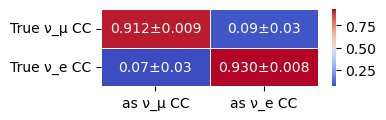

In [22]:
import seaborn as sns
variable_names1 = ['as ν_μ CC', 'as ν_e CC']
variable_names2 = ['True ν_μ CC', 'True ν_e CC']

annot_arr = np.array([['0.912±0.009','0.09±0.03'],
                      ['0.07±0.03','0.930±0.008']], dtype = str)

plt.figure(figsize = (3.5,1))
heatmap = sns.heatmap(confusion, annot=annot_arr, cmap='coolwarm', fmt="s", linewidths=.5, square=False)
heatmap.set_xticklabels(variable_names1, rotation=0)
heatmap.set_yticklabels(variable_names2, rotation=0)
#plt.title("Confusion Matrix")±±±±±
plt.show()

In [23]:
predictions = []
for n, i in enumerate(f):
    if i >= -8.5:
        #track
        if particle[n] == 13. or particle[n] == -13.:
            predictions.append(0)
        else:
            predictions.append(2)
    if i < -8.5:
        #shower
        if particle[n] == 11. or particle[n] == -11.:
            predictions.append(1)
        else:
            predictions.append(2)        

In [24]:
from sklearn.metrics import confusion_matrix

conf_matrix = confusion_matrix(eventlabel, predictions)
conf_matrix_decimals = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

In [25]:
conf_matrix

array([[855,   5, 173],
       [  3, 955, 152],
       [  7,  10, 569]], dtype=int64)

Text(50.722222222222214, 0.5, 'True Label')

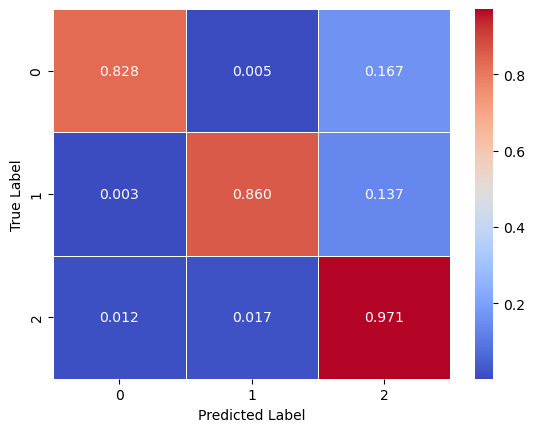

In [26]:
heatmap = sns.heatmap(conf_matrix_decimals, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, square=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')


In [27]:
tracks = []
trktruth = []
showers = []
shwtruth = []
for n, i in enumerate(f):
    if i >= -8.5:
        tracks.append(n)
        if particle[n] == 13. or particle[n] == -13.:
            trktruth.append(1)
        else:
            trktruth.append(0)
    if i < -8.5:
        showers.append(n)
        if particle[n] == 11. or particle[n] == -11.:
            shwtruth.append(1)
        else:
            shwtruth.append(0)

In [28]:
x_test_track = x_test[tracks]
y_test_track = np.array(trktruth)
x_test_shower = x_test[showers]
y_test_shower = np.array(shwtruth)

In [29]:
np.shape(x_test_shower)

(1390, 5)

In [30]:
trackevents = testing[tracks]
showerevents = testing[showers]
len(trackevents), len(showerevents)

(1339, 1390)

In [31]:
def trkbiggest():
    biggest = []
    badevents = []
    
    for n in trackevents:
        nhits = 0
        big = []
        idx = np.where(events.event_number == n)[0]
        
        for i in idx:
            x = events.reco_hits_x_w[i]
            z = events.reco_hits_w[i]
            pdg = events.mc_pdg[i]
            purity = events.purity[i]
            complete = events.completeness[i]
            
            if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
                if len(x) > nhits:
                    nhits = len(x)
                    big.append(i)
        
        if len(big) != 0:
            biggest.append(big[-1])
        else:
            badevents.append(n)
        
    
    return biggest, badevents

In [32]:
bigg, badevents = trkbiggest()

In [33]:
newevents = [i for i in trackevents if i not in badevents]

In [34]:
def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def trkfeatures():
    data = []
    label = []

    for i in bigg:

        # features
        entry = []

        # hits, pdg code, purity, completeness, adc values, vertex coordinates

        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        pdg = events.mc_pdg[i]
        purity = events.purity[i]
        complete = events.completeness[i]

        adc = events.reco_adcs_w[i]
        vx = events.reco_particle_vtx_x[i]
        vz = events.reco_particle_vtx_w[i]

        xlen = 0.1*(max(x) - min(x))

        if pdg == 13. or pdg == -13.:
            label.append(1) # muon
        else:
            label.append(0) # other

        best_inliers = []
        best_model = None
        sample_size = 10
        max_iterations = 100

        for _ in range(max_iterations):
            sample_size = min(sample_size, len(x))
            sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
            x_sample = x[sample_indices]
            z_sample = z[sample_indices]

            m, c = fit_line(x_sample, z_sample)
            residuals = calculate_residuals(x, z, m, c)
            inliers = np.where(residuals < (0.15*xlen))[0]

            if len(inliers) > len(best_inliers):
                best_inliers = inliers
                best_model = (m, c)

        if len(best_inliers) > 0:
            m, c = best_model

            # changing the coordinates into longitudinal and tranverse from best line

            znew = z - c
            angle = -math.atan(m)
            l = x * np.cos(angle) - znew * np.sin(angle)
            t = x * np.sin(angle) + znew * np.cos(angle)

            # NEW 1: Length

            lmin, lmax = np.min(l), np.max(l)
            length = lmax - lmin
            entry.append(length)

            # NEW 2: Sum of charge 

            summ = np.sum(adc)
            charge = summ/length
            entry.append(charge)

            data.append(entry)


        else:
            entry.append(1)
            entry.append(1)
            data.append(entry)

    return data, label

In [35]:
trackdata, tracktruth = trkfeatures()

In [36]:
np.shape(trackdata)

(1306, 2)

In [37]:
trackdata = np.array(trackdata)
tracktruth = np.array(tracktruth)

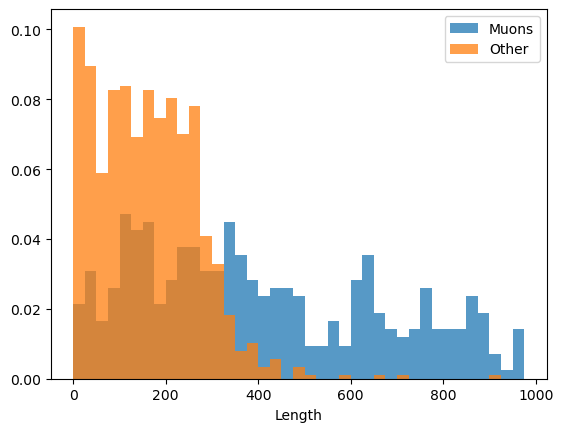

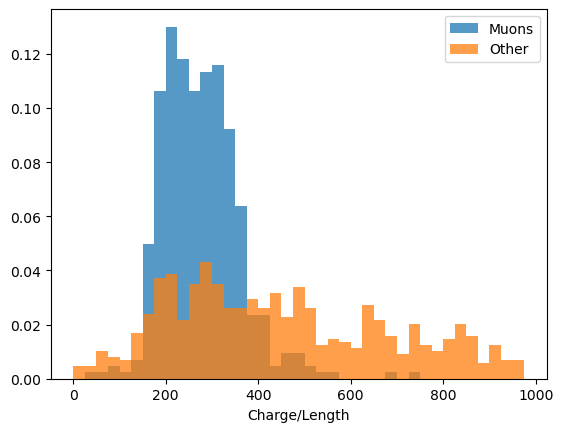

In [38]:
feature_1_true = trackdata[tracktruth == 1, 0]
feature_1_false = trackdata[tracktruth == 0, 0]
feature_2_true = trackdata[tracktruth == 1, 1]
feature_2_false = trackdata[tracktruth == 0, 1]

bin_edges = np.arange(0, 1000, 25)
hist1, _ = np.histogram(feature_1_true, bins=bin_edges)
hist2, _ = np.histogram(feature_1_false, bins=bin_edges)

hist1_normalized = hist1 / len(feature_1_true)
hist2_normalized = hist2 / len(feature_1_false)

plt.bar(bin_edges[:-1], hist1_normalized, width=25, align='edge', alpha=0.75, label='Muons')
plt.bar(bin_edges[:-1], hist2_normalized, width=25, align='edge', alpha=0.75, label='Other')

plt.xlabel('Length')
plt.legend()
plt.show()

bin_edges = np.arange(0, 1000, 25)
hist1, _ = np.histogram(feature_2_true, bins=bin_edges)
hist2, _ = np.histogram(feature_2_false, bins=bin_edges)

hist1_normalized = hist1 / len(feature_2_true)
hist2_normalized = hist2 / len(feature_2_false)

plt.bar(bin_edges[:-1], hist1_normalized, width=25, align='edge', alpha=0.75, label='Muons')
plt.bar(bin_edges[:-1], hist2_normalized, width=25, align='edge', alpha=0.75, label='Other')

plt.xlabel('Charge/Length')
plt.legend()
plt.show()

In [39]:
indices_70_percentt = np.random.choice(len(tracktruth), size=int(0.7 * len(tracktruth)), replace=False)
x_train_trk = trackdata[indices_70_percentt]
y_train_trk = tracktruth[indices_70_percentt]
x_test_trk = np.delete(trackdata, indices_70_percentt, axis=0)
y_test_trk = np.delete(tracktruth, indices_70_percentt, axis=0)

In [40]:
# Create the BDT with a base decision tree classifier (this is the default base classifier, included for illustration)
base = DecisionTreeClassifier(max_depth=14)
bdtt = AdaBoostClassifier(estimator=base, n_estimators=100, random_state=0)
# Fit the BDT to the training set
bdtt.fit(x_train_trk, y_train_trk)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=14),
                   n_estimators=100, random_state=0)

In [41]:
# Check the training set classification performance
bdtt.score(x_test_trk, y_test_trk)

0.8520408163265306

In [42]:
allll = np.concatenate((x_train_trk, x_test_trk))
allll

array([[ 135.90201,  510.1977 ],
       [ 218.42896,  173.86728],
       [ 283.07   , 2833.476  ],
       ...,
       [ 168.51959,  294.8986 ],
       [ 151.32373,   23.9057 ],
       [ 224.98083, 1049.7227 ]], dtype=float32)

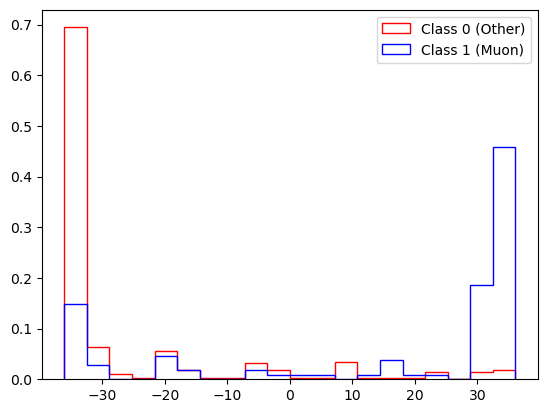

In [43]:
ft = bdtt.decision_function(x_test_trk)
min_f = np.round(np.min(ft), 1)
max_f = np.round(np.max(ft), 1)
#bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)
bins = 20
cls_0_f = ft[np.where(y_test_trk == 0)]
cls_1_f = ft[np.where(y_test_trk == 1)]
weights_0 = np.ones_like(cls_0_f) / len(cls_0_f)
weights_1 = np.ones_like(cls_1_f) / len(cls_1_f)
plt.hist(cls_0_f, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0 (Other)')
plt.hist(cls_1_f, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1 (Muon)')
plt.legend()

In [44]:
def shwbiggest():
    biggest = []
    badevents = []
    
    for n in showerevents:
        nhits = 0
        big = []
        idx = np.where(events.event_number == n)[0]
        
        for i in idx:
            x = events.reco_hits_x_w[i]
            z = events.reco_hits_w[i]
            pdg = events.mc_pdg[i]
            purity = events.purity[i]
            complete = events.completeness[i]
            
            if len(x) > 10 and pdg != 0 and purity > 0.75 and complete > 0.75:
                if len(x) > nhits:
                    nhits = len(x)
                    big.append(i)
        
        if len(big) != 0:
            biggest.append(big[-1])
        else:
            badevents.append(n)
        
    return biggest, badevents

In [45]:
biggg, badeventss = shwbiggest()

In [46]:
neweventss = [i for i in showerevents if i not in badeventss]

In [47]:
def fit_line(x, y):
    A = np.vstack([x, np.ones_like(x)]).T
    m, c = np.linalg.lstsq(A, y, rcond=None)[0]
    return m, c

def calculate_residuals(x, y, m, c):
    #y_predicted = (m*x) + c
    perpdist = abs(((-m*x) + y - c) / np.sqrt(m**2 + 1))
    #residuals = np.abs(perpdist - y_predicted)
    return perpdist

def shwfeatures():
    data = []
    label = []

    for i in biggg:

        # features
        entry = []

        # hits, pdg code, purity, completeness, adc values, vertex coordinates

        x = events.reco_hits_x_w[i]
        z = events.reco_hits_w[i]
        pdg = events.mc_pdg[i]
        purity = events.purity[i]
        complete = events.completeness[i]

        adc = events.reco_adcs_w[i]
        vx = events.reco_particle_vtx_x[i]
        vz = events.reco_particle_vtx_w[i]

        xlen = 0.1*(max(x) - min(x))

        if pdg == 11. or pdg == -11.:
            label.append(1) # electron
        else:
            label.append(0) # other

        best_inliers = []
        best_model = None
        sample_size = 10
        max_iterations = 100

        for _ in range(max_iterations):
            sample_size = min(sample_size, len(x))
            sample_indices = np.random.choice(len(x), size=sample_size, replace=False)
            x_sample = x[sample_indices]
            z_sample = z[sample_indices]

            m, c = fit_line(x_sample, z_sample)
            residuals = calculate_residuals(x, z, m, c)
            inliers = np.where(residuals < (0.15*xlen))[0]

            if len(inliers) > len(best_inliers):
                best_inliers = inliers
                best_model = (m, c)

        if len(best_inliers) > 0:
            m, c = best_model

            # changing the coordinates into longitudinal and tranverse from best line

            znew = z - c
            angle = -math.atan(m)
            l = x * np.cos(angle) - znew * np.sin(angle)
            t = x * np.sin(angle) + znew * np.cos(angle)
            
            # NEW 1: Vtx dist
            
            nx = events.true_neutrino_vtx_x[i]
            nw = events.true_neutrino_vtx_w[i]
            dists = []
            for n, i in enumerate(x):
                dist = np.sqrt((nx - i) ** 2 + (nw - z[n]) ** 2)
                dists.append(dist)
            entry.append(min(dists))
            
            
            #px = x[0]
            #pw = z[0]
            #nx = events.true_neutrino_vtx_x[i]
            #nw = events.true_neutrino_vtx_w[i]
            
            
            #px = events.reco_particle_vtx_3d_x[i]
            #py = events.reco_particle_vtx_3d_y[i]
            #pz = events.reco_particle_vtx_3d_z[i]
            #nx = events.neutrino_vtx_3d_x[i]
            #ny = events.neutrino_vtx_3d_y[i]
            #nz = events.neutrino_vtx_3d_z[i]
            
            #pcord = np.array((px, pw))
            #ncord = np.array((nx, nw))
            #squared_diff = (pcord - ncord) ** 2
            #distance = np.sqrt(np.sum(squared_diff))
            #entry.append(distance)
            
            # NEW 2: Charge at start
            
            lmin, lmax = np.min(l), np.max(l)
            length = lmax - lmin
            
            vznew = vz - c

            vl = vx * np.cos(angle) - vznew * np.sin(angle)
            vt = vx * np.sin(angle) + vznew * np.cos(angle)

            if max(l) < vl:
                l *= -1

            combined = list(zip(l, t, adc))
            sort = sorted(combined, key = lambda coord: coord[0])

            lnew, tnew, adcnew = zip(*sort)

            percent = int(0.1 * len(adcnew))
            X = adcnew[:percent]
            Xsum = np.sum(X)
            newww = Xsum/(0.1*length)
            entry.append(newww)
            
            data.append(entry)


        else:
            entry.append(1)
            entry.append(1)
            data.append(entry)

    return data, label

In [48]:
showerdata, showertruth = shwfeatures()

In [49]:
showerdata = np.array(showerdata)
showertruth = np.array(showertruth)

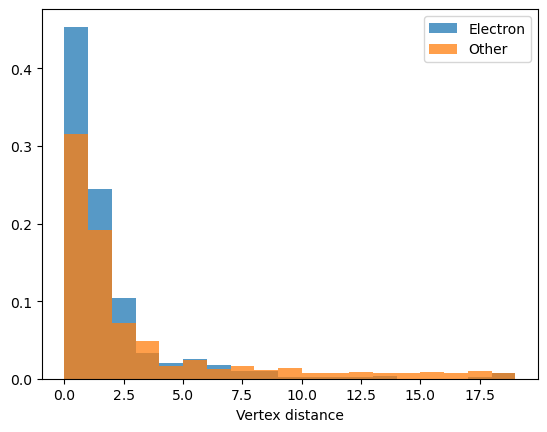

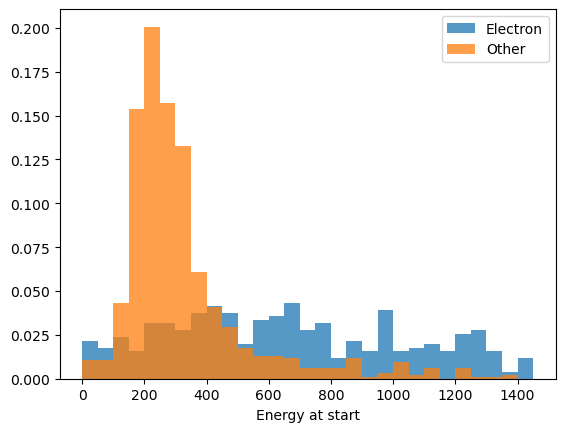

In [50]:
feature_1_true = showerdata[showertruth == 1, 0]
feature_1_false = showerdata[showertruth == 0, 0]
feature_2_true = showerdata[showertruth == 1, 1]
feature_2_false = showerdata[showertruth == 0, 1]

bin_edges = np.arange(0, 20, 1)
hist1, _ = np.histogram(feature_1_true, bins=bin_edges)
hist2, _ = np.histogram(feature_1_false, bins=bin_edges)

hist1_normalized = hist1 / len(feature_1_true)
hist2_normalized = hist2 / len(feature_1_false)

plt.bar(bin_edges[:-1], hist1_normalized, width=1, align='edge', alpha=0.75, label='Electron')
plt.bar(bin_edges[:-1], hist2_normalized, width=1, align='edge', alpha=0.75, label='Other')

plt.xlabel('Vertex distance')
plt.legend()
plt.show()

bin_edges = np.arange(0, 1500, 50)
hist1, _ = np.histogram(feature_2_true, bins=bin_edges)
hist2, _ = np.histogram(feature_2_false, bins=bin_edges)

hist1_normalized = hist1 / len(feature_2_true)
hist2_normalized = hist2 / len(feature_2_false)

plt.bar(bin_edges[:-1], hist1_normalized, width=50, align='edge', alpha=0.75, label='Electron')
plt.bar(bin_edges[:-1], hist2_normalized, width=50, align='edge', alpha=0.75, label='Other')

plt.xlabel('Energy at start')
plt.legend()
plt.show()

In [51]:
indices_70_percents = np.random.choice(len(showertruth), size=int(0.7 * len(showertruth)), replace=False)
x_train_shw = showerdata[indices_70_percents]
y_train_shw = showertruth[indices_70_percents]
x_test_shw = np.delete(showerdata, indices_70_percents, axis=0)
y_test_shw = np.delete(showertruth, indices_70_percents, axis=0)

In [52]:
# Create the BDT with a base decision tree classifier (this is the default base classifier, included for illustration)
base = DecisionTreeClassifier(max_depth=14)
bdts = AdaBoostClassifier(estimator=base, n_estimators=100, random_state=0)
# Fit the BDT to the training set
bdts.fit(x_train_shw, y_train_shw)

AdaBoostClassifier(estimator=DecisionTreeClassifier(max_depth=14),
                   n_estimators=100, random_state=0)

In [53]:
# Check the training set classification performance
bdtt.score(x_test_shw, y_test_shw)

0.5220588235294118

In [54]:
#allll = np.concatenate((x_train_shw, x_test_shw))

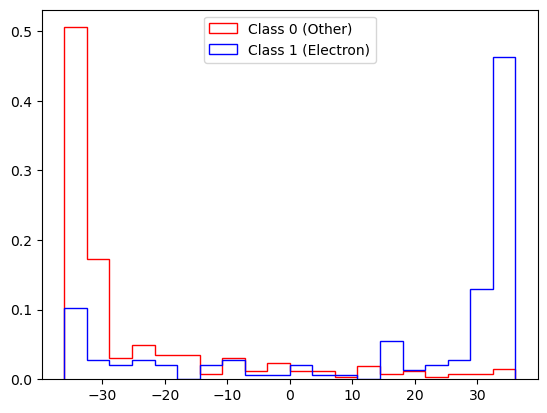

In [55]:
fs = bdts.decision_function(x_test_shw)
min_f = np.round(np.min(fs), 1)
max_f = np.round(np.max(fs), 1)
#bins = np.linspace(min_f, max_f, 4 * int((max_f - min_f) / 0.1) + 1)
bins = 20
cls_0_f = fs[np.where(y_test_shw == 0)]
cls_1_f = fs[np.where(y_test_shw == 1)]
weights_0 = np.ones_like(cls_0_f) / len(cls_0_f)
weights_1 = np.ones_like(cls_1_f) / len(cls_1_f)
plt.hist(cls_0_f, color='r', weights=weights_0, bins=bins, histtype='step', label='Class 0 (Other)')
plt.hist(cls_1_f, color='b', weights=weights_1, bins=bins, histtype='step', label='Class 1 (Electron)')
plt.legend()

In [56]:
truth = np.load("truth_data.npy")
truth

array([0, 0, 0, ..., 1, 1, 1])

In [57]:
tra = np.array(truth[newevents])
sha = np.array(truth[neweventss])

trb = np.delete(tra, indices_70_percentt, axis=0)
shb = np.delete(sha, indices_70_percents, axis=0)

In [58]:
len(trb), len(ft)

(392, 392)

In [59]:
len(shb), len(fs)

(408, 408)

In [60]:
pred = []
for n, i in enumerate(ft):
    if i >= -10.5:
        pred.append(1)
    if i < -10.5:
        pred.append(0)
trut = y_test_trk

In [61]:
confusion_matrix(trut, pred)

array([[242,  43],
       [ 26,  81]], dtype=int64)

[[ 88  20 179]
 [ 17 115 204]
 [ 19  16 142]]


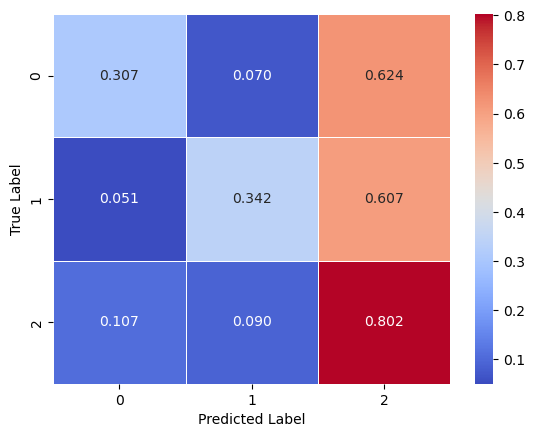

In [69]:
tcut = -10
scut = -10
predictions = []
for n, i in enumerate(ft):
    if i >= tcut:
        predictions.append(0)
    if i < tcut:
        predictions.append(2)
for n, i in enumerate(fs):
    if i >= scut:
        predictions.append(1)
    if i < scut:
        predictions.append(2)
truthh = np.concatenate((trb,shb))
conf_matrix = confusion_matrix(truthh, predictions)
conf_matrix_decimals = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
heatmap = sns.heatmap(conf_matrix_decimals, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, square=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
print(conf_matrix)

In [63]:
conf_matrix = confusion_matrix(truthh, predictions)
conf_matrix_decimals = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]

In [64]:
conf_matrix

array([[ 82,  12, 193],
       [ 11, 109, 216],
       [ 13,  14, 150]], dtype=int64)

Text(50.722222222222214, 0.5, 'True Label')

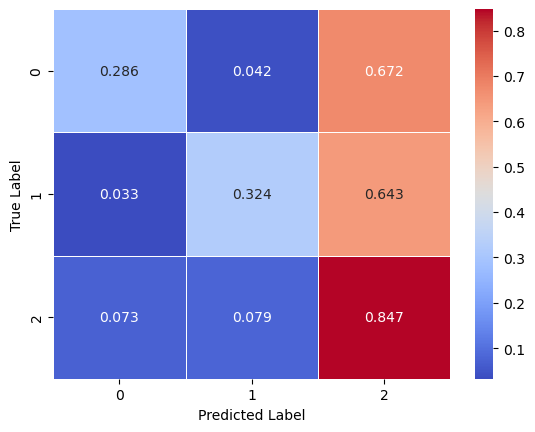

In [65]:
heatmap = sns.heatmap(conf_matrix_decimals, annot=True, cmap='coolwarm', fmt=".3f", linewidths=.5, square=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

In [66]:
TIT = cls_1_f
SIT = cls_0_f

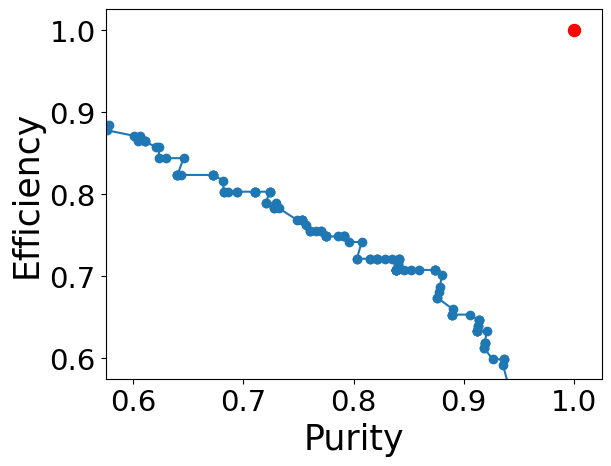

Best cut: 13.0
At distance: 0.31851987017040156
With AUC: 0.8287760588870166


In [67]:
cuts = np.arange(-35, 35, 0.5)
efficiency = []
purity = []

purity.append(0)
efficiency.append(1)

for i in cuts:
    goodtrk = []
    badtrk = []
    goodshw = []
    badshw = []
    for n in TIT:
        if n >= i:
            goodtrk.append(n)
        else:
            badtrk.append(n)
    for k in SIT:
        if k >= i:
            badshw.append(k)
        else:
            goodshw.append(k)

    eff = len(goodtrk)/(len(TIT))
    pur = len(goodtrk)/(len(goodtrk)+len(badshw))

    efficiency.append(eff)
    purity.append(pur)

purity.append(1)
efficiency.append(0)

plt.scatter(purity, efficiency)
plt.plot(purity, efficiency)
plt.scatter(1, 1, s=75, c='r')
#plt.xlim(0.6,1.025)
#plt.ylim(0.6,1.025)
plt.xlabel('Purity', fontsize=25)
plt.ylabel('Efficiency', fontsize=25)
#plt.title('ROC Curve for Track Likelihood')
plt.xticks(np.arange(0.6, 1.1, step=0.1), fontsize = 21)
plt.yticks(np.arange(0.6, 1.1, step=0.1), fontsize = 21)
plt.xlim(0.575,1.025)
plt.ylim(0.575,1.025)
plt.show()

np.save("CE_BDT", efficiency)
np.save("CP_BDT", purity)

area = np.trapz(efficiency, x=purity)

point = np.array([1, 1])
data_points = np.column_stack((purity, efficiency))
distances = np.linalg.norm(data_points - point, axis=1)
closest_index = np.argmin(distances)
closest_point = data_points[closest_index]
dist = distances[closest_index]
cutpoint = cuts[closest_index]

print('Best cut:', cutpoint)
print('At distance:', dist)
print('With AUC:', area)

#efficiency (true tracks as tracks/total true tracks)
#purity (true tracks as tracks/number we have called tracks)

In [68]:
TTAT = []
TTAS = []
TSAT = []
TSAS = []

for i, n in enumerate(TIT):
    if n >= cutpoint:
        TTAT.append(n)
        leng1.append(trkleng[i])
        part1.append(trkpart[i])
    if n < cutpoint:
        TTAS.append(n)
        leng2.append(trkleng[i])
        part2.append(trkpart[i])
        
for i, k in enumerate(SIT):
    if k >= cutpoint:
        TSAT.append(k)
        leng3.append(shwleng[i])
        part3.append(shwpart[i])
    if k < cutpoint:
        TSAS.append(k)
        leng4.append(shwleng[i])
        part4.append(shwpart[i])

TTATprob = len(TTAT)/(len(TTAT)+len(TTAS))
TTASprob = len(TTAS)/(len(TTAT)+len(TTAS))
TSATprob = len(TSAT)/(len(TSAT)+len(TSAS))
TSASprob = len(TSAS)/(len(TSAT)+len(TSAS))

confusion = np.array(([TTATprob, TTASprob],[TSATprob, TSASprob]))
print(confusion)

e1 = np.sqrt((TTATprob*(1-TTATprob))/len(TTAT))
e2 = np.sqrt((TTASprob*(1-TTASprob))/len(TTAS))
e3 = np.sqrt((TSATprob*(1-TSATprob))/len(TSAT))
e4 = np.sqrt((TSASprob*(1-TSASprob))/len(TSAS))

error = np.array(([e1, e2],[e3, e4]))
print(error)

NameError: name 'leng1' is not defined

In [ ]:
import seaborn as sns
variable_names1 = ['as Track', 'as Shower']
variable_names2 = ['True Track', 'True Shower']

annot_arr = np.array([['0.980±0.002','0.02±0.01'],
                      ['0.03±0.01','0.972±0.002']], dtype = str)

plt.figure(figsize = (3.5,1))
heatmap = sns.heatmap(confusion, annot=annot_arr, cmap='coolwarm', fmt="s", linewidths=.5, square=False)
heatmap.set_xticklabels(variable_names1, rotation=0)
heatmap.set_yticklabels(variable_names2, rotation=0)
#plt.title("Confusion Matrix")±±±±±
plt.show()

In [ ]:
#print(max(trkleng))
#print(max(shwleng))
bin_edges = np.arange(10, 310, 10)

hist1, _ = np.histogram(trkleng, bins=bin_edges)
hist2, _ = np.histogram(leng1, bins=bin_edges)

#hist1_normalized = hist1 / len(trkleng)
#hist2_normalized = hist2 / len(leng1)

plt.bar(bin_edges[:-1], hist1, width=10, align='edge', alpha=0.75, label='All True Showers')
plt.bar(bin_edges[:-1], hist2, width=10, align='edge', alpha=0.75, label='True Showers as Showers')
#plt.title('')
plt.xlabel('n Hits In Particle')
plt.legend(loc='upper center')
plt.show()

xvalues = np.arange(10, 300, 10)
eff = hist2/hist1
error = []

for i, val in enumerate(eff):
    err = np.sqrt((val*(1-val))/(hist1[i]+hist2[i]))
    error.append(err)

#print(xvalues)
#print(eff)
#print(error)

plt.errorbar(xvalues, eff, yerr=error, fmt='o', elinewidth=2, ecolor='red', capsize=5, ms=10)
#plt.scatter(xvalues, (hist2/hist1))
plt.xlabel('n Hits in Particle')
plt.ylabel('Efficiency')
#plt.xticks(fontsize = 21)
#plt.yticks(fontsize = 21)
plt.ylim(0.5,1.02)
plt.show()